### Goal : Predict RPC (Revenue per Click) 


### Process : 


    - 0 LOAD DATA 
    - 0'DATA PREPROCESS
    - 1 DATA OVERVIEW
        -2.0 Date
        -2.1 Account_ID
        -2.2 Campaign_ID
        -2.3 Ad_group_ID
        -2.4 Keyword_ID
        -2.5 Device_ID
        -2.6 Match_type_ID
        -2.7 Revenue	
        -2.8 Clicks	
        -2.9 RPC
        -2.10 Conversions	
    - 2 FEATURE ENGINEERING 
    - 3 FEATURE ANALYSIS 
    - 4 FEATURE RECOMMENDATION 



### Hypotheses :
- Hierarchy : Account -> Campaign -> Ad group -> Keywords
- Account : TA group (target audidnece)
- Campaign : Ad group in similar scope
- Ad group : key words in the same product 


#### =========================================================================

#### Selected features:
- Keyword_ID, (aggregrated, mean...)
- Device_ID : Mobile / computer / Tablet
- conversion : positve with RPC, revenue
- Match type
- avg revenue, RPC, click, Conversions..
- avg revenue, RPC, click, Conversions on account_id ..
- Device_ID

In [2]:
# load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt

plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


## - 0) Load data

In [5]:
# load data 
df_train = pd.read_csv('/Users/yennanliu/analysis/GY_guide/data/train.csv')
df_predict = pd.read_csv('/Users/yennanliu/analysis/GY_guide/data/prediction.csv')



## - 0') Data preprocess

In [73]:
# data preprocess 
df_train.Date = pd.to_datetime(df_train.Date)
df_train['RPC'] = df_train['Revenue']/df_train['Clicks']

## -1)  Data overview

In [6]:
df_train.head(2)

,Date,Keyword_ID,Ad_group_ID,Campaign_ID,Account_ID,Device_ID,Match_type_ID,Revenue,Clicks,Conversions
0,2014-12-14,88883763407,1042143654876,71672332180,861287123742,298643508640,95725474456,0.0,2,0
1,2014-12-14,837336088038,1038839743255,685307833020,654870334100,298643508640,95725474456,0.0,2,0


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8285423 entries, 0 to 8285422
Data columns (total 10 columns):
Date             object
Keyword_ID       int64
Ad_group_ID      int64
Campaign_ID      int64
Account_ID       int64
Device_ID        int64
Match_type_ID    int64
Revenue          float64
Clicks           int64
Conversions      int64
dtypes: float64(1), int64(8), object(1)
memory usage: 632.1+ MB


> - Train data has 8285423 records, no missing value
- 1 datatime column, 3 numerical, and 6 category columns 

### - 1-0) Date

In [72]:
print ('min date : ', df_train.Date.min())
print ('max date : ', df_train.Date.max())
print ('time period : ', df_train.Date.max() - df_train.Date.min())

min date :  2014-12-14 00:00:00
max date :  2015-04-07 00:00:00
time period :  114 days 00:00:00


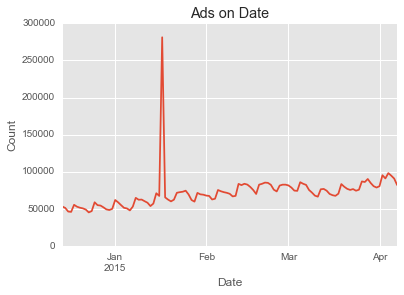

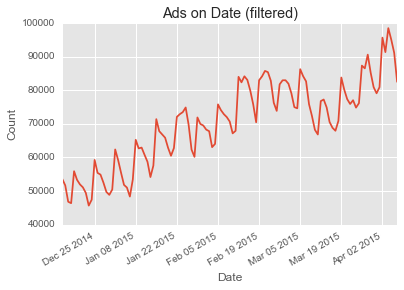

In [90]:
df_train.groupby('Date').count()['Clicks'].plot()

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Ads on Date')
plt.show()

#========================================================================

df_train_ = df_train[df_train.Date != '2015-01-17']
df_train_.groupby('Date').count()['Clicks'].plot()

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Ads on Date (filtered)')
plt.show()


In [86]:
df_train.groupby('Date')\
        .count()['Clicks']\
        .reset_index()\
        .sort_values('Clicks', ascending=False)\
        .head(3)

,Date,Clicks
34,2015-01-17,281063
111,2015-04-04,98501
109,2015-04-02,95677


>- Averagely there are 50k - 90k daily ads push (combination of account/campaign...)
- There was an `sudden boost` of ads data on `2015-01-17` with unknow reason, have to deal with that data specially and check possible causes
- `Transformed` train data since 2014-12-14 to 2015-04-07. 114 days period



### -1-1) Account_ID

In [12]:
print ('Account ID counts : ', len(set(df_train.Account_ID)))

Account ID counts :  16


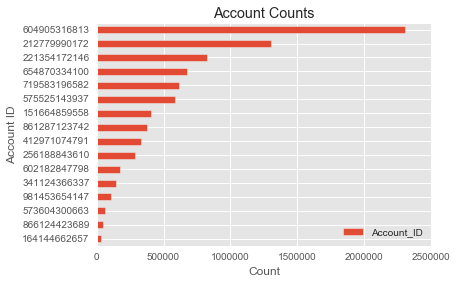

In [42]:
pd.DataFrame(df_train.Account_ID.value_counts()).sort_values('Account_ID').plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Account ID')
plt.title('Account Counts')

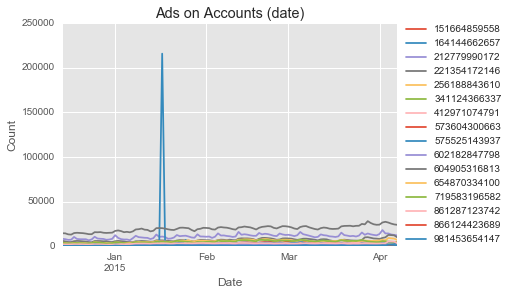

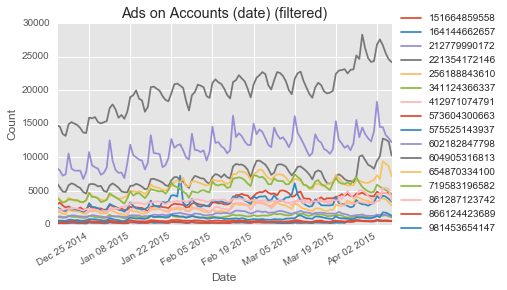

In [91]:
df_account =  df_train.groupby(['Date','Account_ID']).count()['Clicks'].reset_index()
df_account.columns=['Date','Account_ID','count']
df_account_pivot = pd.pivot_table(df_account,columns='Account_ID',index='Date',values='count')
df_account_pivot.plot()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Ads on Accounts (date)')


#========================================================================
 
df_train_ = df_train[df_train.Date != '2015-01-17']
df_account_ =  df_train_.groupby(['Date','Account_ID']).count()['Clicks'].reset_index()
df_account_.columns=['Date','Account_ID','count']
df_account_pivot_ = pd.pivot_table(df_account_,columns='Account_ID',index='Date',values='count')
df_account_pivot_.plot()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Ads on Accounts (date) (filtered)')




> 
- There are total 16 different account group in train data
- Some groups have `MUCH MORE` records than others, and take 
   big proportion of total data. Have to check how does this phenomenon   affect revenue/RPC   
- `604905316813 : accounts 27% of all data
212779990172 : accounts 15% of all data `

  

In [92]:
#df_train.head()